In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Описание задачи

<center><font size=4>
    Рассм. переменную $Y$, принимающую разные зачения в зав. от бинарной $W$ - воздействия.<br>
    Для i-ого наблюдения имеем $Y_i(1), Y_i(0)$ -поведение под воздействием и без<br>
    <br>
    $$\tau_i = Y_i(1) - Y_i(0)$$
    <br> - набл. эффект от воздейств.<br>
    <br>
    $$CATE: \tau_i(X_i) = \mathbb{E}[Y_i(1)|X_i] - \mathbb{E}[Y_i(0)|X_i]$$
    <br> - ожид. эффект от воздейств.<br>
    <br>
    Применение - медицина (эффект лекарств), реклама (выделение убеждаемых клиентов), социология, экономика.
    <br>
    <img src="8.png" alt="drawing" width="300"/>   
    <br>
    <br>
    <br>
    Вернёмся к формулам, запишем<br>
    <br>
    $$Y_i^{obs} = Y_i(1)W_i + Y_i(0)(1 - W_i)$$<br>
    Возникает вопрос:<br>
    <br>
    $$?\; \mathbb{E}[Y_i(1)|X_i] = \mathbb{E}[Y_i^{obs}|X_i, W_i = 1] \;(1)$$
    $$?\; \mathbb{E}[Y_i(0)|X_i] = \mathbb{E}[Y_i^{obs}|X_i, W_i = 0] \;(2)$$<br>
    На примере классификации:<br>
    <br>
    $$\mathbb{E}[Y_i(1)|X_i] = P(Y_i(1) = 1|X_i) = P(Y_i^{obs} = 1|X_i, treat_i = 1)$$<br>
    $treat_i$ является абстрактной сл. величиной. Её главное св-во - она не зависит от $Y_i(1), Y_i(0)$.<br>
    Если задаваемое нами $W_i$ также не зав. от $Y_i(1), Y_i(0)$, то формулы 1 и 2 справедл. (усл-ие 3)<br>
    Сами $Y_i(1), Y_i(0)$ зависят от $X_i$.<br>
    <br>
    Коротко данные факты записывают как<br>
    <br>
    $$CIA: {Y_i(1), Y_i(0)} \bot W_i|X_i$$ (Conditional Independence Assumption).<br>
    <br>
    Для условия 3 достаточно, чтобы $W_i$ не зав. от $X_i$, или $P(W_i = 1|X_i) = 1/2$.<br>
    <br>
    <br>
    <br>
    Далее будем строить модели для оценки<br>
    <br>
    $$\mathbb{E}[Y_i(1)|X_i] - \mathbb{E}[Y_i(0)|X_i]$$<br>
    $$\mathbb{E}[Y_i(1) - Y_i(0)|X_i]$$<br>
    (Либо по слагаемым, либо суммарно)
</font></center>

# Валидация uplift моделей

<center><font size=4>
    Гл. проблема - отсутствие эталонного знач. $uplift$ для данного тестов. примера $X_i$.<br>
    Невозможно одновр. обеспечить $W_i = 0/1$ (как для абстр. $treat_i$).<br>
    <br>
    Цель модели - выделить клиентов, которые сделают покупку только под воздействием.
    <br>
    <br>
    Типы клиентов:
    <img src="3.png" alt="drawing" width="600"/>   
</font></center>

<center><font size=4>
    1) Uplift_at_k.<br>
    <br>
    $$uplift = model.predict(X_{val})$$<br>
    $$Y_{val} = Y_{val}[argsort(uplift)]$$<br>
    $$\hat{P}_1 = mean(Y_{val}[:k \%] == 1)$$<br>
    $$\hat{P}_0 = mean(Y_{val}[:k \%] == 0)$$<br>
    $$score = \hat{P}_1 - \hat{P}_0$$ - оценка $uplift$ от взаимодействия с $k \%$ выборки.<br>
    <br>
    2) Uplift_by_percentile.<br>
    <br>
    $$uplift = model.predict(X_{val})$$<br>
    $$Y_{val} = Y_{val}[argsort(uplift)]$$<br>
    Далее делим выборку на процентили и поступаем аналогично $uplift\_at\_k$ для каждого слота.
    $$score_i = \hat{P}_{1i} - \hat{P}_{0i}$$
    <img src="5.png" alt="drawing" width="800"/>    
    <img src="6.png" alt="drawing" width="700"/><br>
    <br>
    3) Qini curve <br>
    <br>
    $$uplift = model.predict(X_{val})$$<br>
    $$Y_{val} = Y_{val}[argsort(uplift)]$$<br>
    <br>
    Пытаемся построить оптимальное ранжирование клиентов из тестов. выборки. Критерий - кумулятивная оценка uplift как в предыд. пунктах.<br>
    <br>
    $$qini(t) = (\frac{Y^T(t)}{N^T(t)} - \frac{Y^C(t)}{N^C(t)})N^T(t)$$<br>
    ($t$ - количество клиентов с воздействием)<br>
    <br>
    Тогда оптимальный порядок таков:
    <br>
    <br>
    1. Убеждаемые, лояльные
    <br>
    2. Потерянные
    <br>
    3. Беспокойные<br>
    <br>
    При таких приоритетах клиентов оценка uplift будет наиболее долго возрастатить, убывая лишь для беспокойных.
    <img src="7.png" alt="drawing" width="850"/><br>
    <br>
    Если случайная модель возрастает, то даже случайное воздействие на клиентов выгодно.
</font></center>

# Изучение данных (Megafon uplift competition)

In [2]:
df = pd.read_csv('train.csv')
del df['id']
df.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,...,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,-3.758503,0.000405,0.356208,-1.004378,3.376919,-6.396371,-2.253712,-6.432606,-0.061507,-1.659301,...,-6.632834,8.454493,0.001296,0.007967,-0.000966,-22.259600,-5.759041,6.241130,-1.176456,0.204190
std,54.881882,0.999419,31.804123,45.291429,53.397644,140.873734,59.810396,74.840857,44.912292,199.625148,...,137.025868,262.840194,1.000368,71.553713,0.999902,500.900364,130.952113,141.211999,21.363662,0.403109
min,-271.659497,-4.372119,-148.870768,-244.446728,-302.574049,-683.126343,-322.731683,-506.202937,-218.466369,-920.347783,...,-633.575178,-1345.838757,-4.756720,-360.713742,-4.516004,-2506.960013,-687.526201,-702.184241,-98.094323,0.000000
25%,-40.693313,-0.673108,-20.758308,-30.644608,-31.865404,-100.762161,-42.313674,-54.840796,-30.327330,-134.565241,...,-99.033996,-167.634846,-0.673780,-48.250836,-0.675549,-357.547278,-93.163915,-88.803657,-15.580688,0.000000
50%,-3.954771,0.000915,0.372583,-0.585368,3.720738,-6.357443,-2.263690,-6.416419,-0.103742,-1.628897,...,-6.784760,8.773280,0.001639,0.045537,-0.002251,-20.695017,-5.774627,6.286783,-1.199895,0.000000
75%,33.174835,0.673056,21.495530,29.027860,38.988940,88.159514,37.709780,41.962767,30.144501,130.948487,...,85.621324,185.382370,0.675779,48.221733,0.673638,313.295748,81.636824,101.558007,13.230410,0.000000
max,250.812280,5.062006,170.053291,235.095937,284.915947,656.482242,293.909622,550.525780,219.628423,1251.776972,...,689.626208,1488.759454,4.727996,384.665348,5.086304,2534.503855,595.321844,630.727101,112.233293,1.000000


In [3]:
conv = df.pop('conversion')
treat = df.pop('treatment_group')
X = df
del df

In [4]:
corr_matrix = X.corr().abs()
corr_pairs = []
for i in range(X.shape[1]):
    for j in range(i):
        if corr_matrix.values[i][j] > 0.95:
            corr_pairs.append([i + 1, j + 1])
    
to_drop = set()
for pair in corr_pairs:
    to_drop.add(max(*pair))
    

print(f'Highly correlated features:\n{corr_pairs}')
print()
print(f'Dropping {to_drop}')

Highly correlated features:
[[12, 10], [21, 15], [25, 15], [25, 21], [43, 28], [45, 20], [47, 11], [49, 42]]

Dropping {43, 12, 45, 47, 49, 21, 25}


<font size=3.5>
    Будем работать со стандартиз. данными.
</font>

In [5]:
X = X.drop(columns=X.columns[list(to_drop)])
X -= X.mean()
X /= X.std()

<font size=3.5>
    Распределения по признакам.
</font>

[]

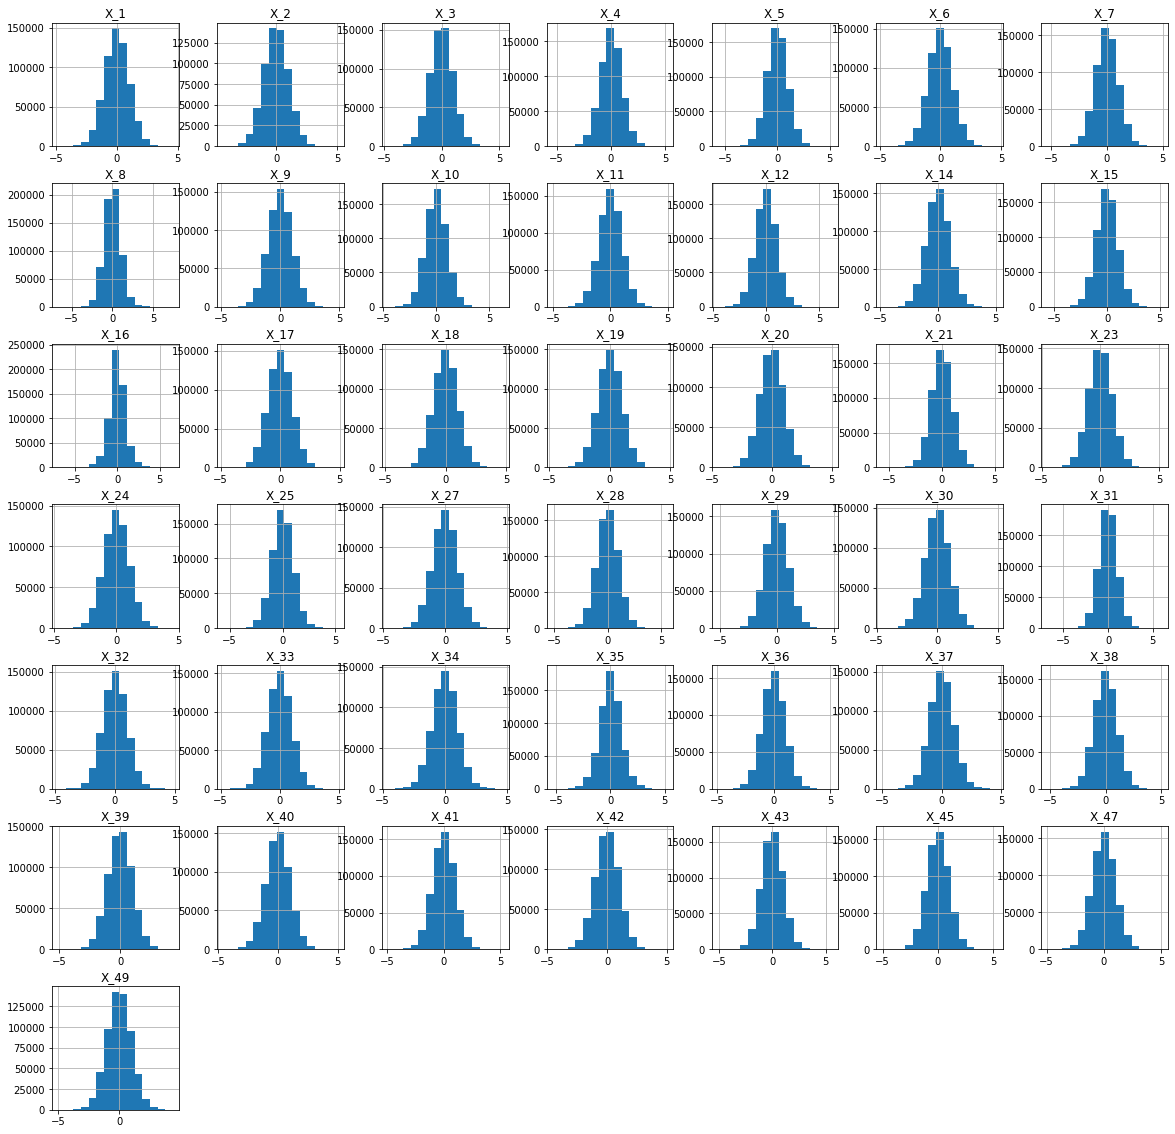

In [6]:
X.hist(figsize=(20, 20), bins=15)
plt.plot()

<font size=3.5>
    Основные 2 разбиения данных.
</font>

In [7]:
from sklearn.model_selection import train_test_split as split

X_train, X_val, c_train, c_val = split(X, conv,
                                       test_size=0.2, shuffle=True,
                                       stratify=treat)

In [8]:
treat_tr = treat[X_train.index]

X_treat = X_train[treat_tr == 'treatment']
X_ctrl = X_train[treat_tr == 'control']

c_treat = c_train[treat_tr == 'treatment']
c_ctrl = c_train[treat_tr == 'control']

treat_tr = 1 * (treat[X_train.index] == 'treatment')
treat_val = 1 * (treat[X_val.index] == 'treatment')

<font size=3.5>
    Основные модели (в дальнейшем).
</font>

In [9]:
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

<font size=3.5>
    Также потребуются методы.
</font>

In [10]:
from sklift.metrics import uplift_at_k
from sklift.metrics import uplift_by_percentile

from sklift.viz import plot_uplift_by_percentile
from sklift.viz import plot_uplift_curve
from sklift.viz import plot_qini_curve

from sklift.metrics import qini_auc_score
from sklift.metrics import uplift_auc_score

# Методы solo-model (s-learner)

<font size=4>
    Используем одну модели одновременно для оценок $$P(Y_i = 1|X_i, treat = 1), P(Y_i = 1|X_i, treat=0)$$ <br>
    Достигается обучением на $X, y$ с добавлением признака 'treatment'. <br>
    $$\widehat{CATE}= \hat{P}(Y_i = 1| X_i, treat = 1) - \hat{P} (Y_i = 1|X_i, treat = 0)$$
</font>

![title](1.png)

In [11]:
from sklift.models import SoloModel

estim = lgb.LGBMClassifier()
model = SoloModel(estim)
model.fit(X_train, c_train, treat_tr)
uplift = model.predict(X_val)

In [12]:
upl_k_score = uplift_at_k(y_true=c_val, uplift=uplift,
                treatment=treat_val,
                k=0.1, strategy='by_group')

print(f'Uplift as k score: {upl_k_score}')

Uplift as k score: 0.30490581971233827


In [13]:
uplift_by_percentile(c_val, uplift, treat_val, 
                     strategy='by_group', 
                     total=True, std=True, bins=10)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,6008,5993,0.466877,0.162022,0.304855,0.006437,0.004760,0.008005
10-20,6008,5993,0.265313,0.130152,0.135161,0.005696,0.004346,0.007165
20-30,6008,5993,0.233023,0.127983,0.105040,0.005454,0.004315,0.006955
30-40,6008,5993,0.225699,0.133489,0.092210,0.005393,0.004393,0.006956
40-50,6007,5993,0.231064,0.130652,0.100411,0.005439,0.004353,0.006966
50-60,6007,5993,0.206426,0.132488,0.073938,0.005222,0.004379,0.006815
60-70,6007,5992,0.183786,0.167390,0.016396,0.004997,0.004823,0.006945
70-80,6007,5992,0.121858,0.192256,-0.070399,0.004221,0.005091,0.006613
80-90,6007,5992,0.094390,0.181409,-0.087019,0.003772,0.004978,0.006246


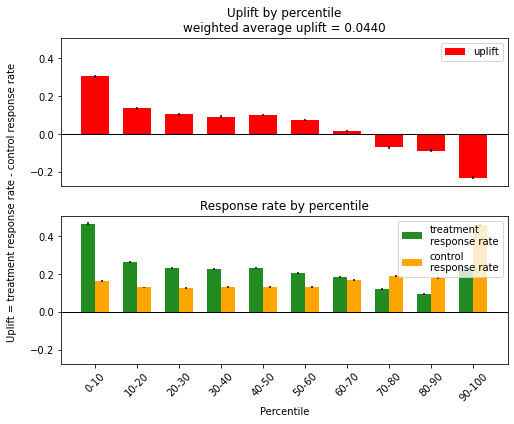

In [14]:
plot_uplift_by_percentile(c_val, uplift, treat_val, 
                          strategy='by_group', kind='bar');

Uplift auc score: 0.1460156420167135


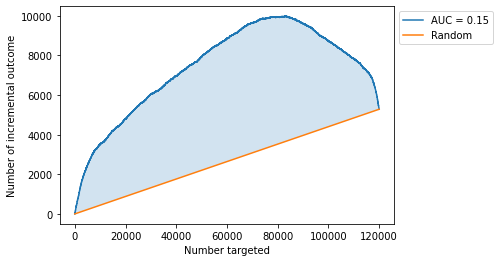

In [15]:
plot_uplift_curve(c_val, uplift, treat_val,
                  perfect=False)

upl_auc_score = uplift_auc_score(c_val, uplift,
                                 treat_val)
print(f'Uplift auc score: {upl_auc_score}')

Qini score: 0.21141142799056672


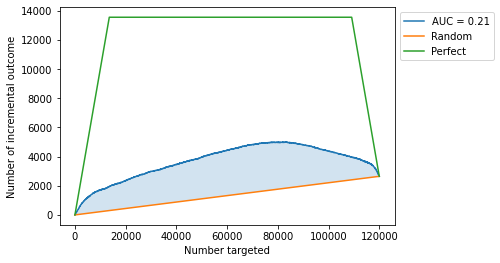

In [16]:
plot_qini_curve(c_val, uplift, treat_val,
                perfect=True)

qini = qini_auc_score(y_true=c_val, uplift=uplift,
                      treatment=treat_val)
print(f'Qini score: {qini}')

# 2 независимые модели (t-learner)

<font size=4>
    Используем 2 модели для оценок
    $$P(Y_i = 1|X_i, treat = 1)$$
    $$P(Y_i = 1|X_i, treat = 0)$$ <br>
    <br>
    Обучаем их отдельно на целевой и контрольной группах<br>
    <br>
    $$\widehat{CATE}= \hat{P_1}(Y_i = 1| X_i) - \hat{P_2} (Y_i = 1|X_i)$$
</font>

![title](9.png)

In [17]:
from sklift.models import TwoModels

estim1 = GaussianNB()
estim2 = GaussianNB()
model = TwoModels(estim1, estim2)
model.fit(X_train, c_train, treat_tr)
uplift = model.predict(X_val)

In [18]:
upl_k_score = uplift_at_k(y_true=c_val, uplift=uplift,
                treatment=treat_val,
                k=0.1, strategy='by_group')

print(f'Uplift as k score: {upl_k_score}')

Uplift as k score: 0.1828698461052226


In [19]:
uplift_by_percentile(c_val, uplift, treat_val, 
                     strategy='by_group', 
                     total=True, std=True, bins=10)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,6008,5993,0.349534,0.166694,0.182839,0.006152,0.004814,0.007812
10-20,6008,5993,0.266478,0.163190,0.103288,0.005704,0.004774,0.007438
20-30,6008,5993,0.248502,0.146504,0.101998,0.005575,0.004568,0.007207
30-40,6008,5993,0.220206,0.149675,0.070532,0.005346,0.004608,0.007058
40-50,6007,5993,0.216747,0.146838,0.069909,0.005316,0.004572,0.007012
50-60,6007,5993,0.196105,0.148507,0.047598,0.005123,0.004593,0.006881
60-70,6007,5992,0.199933,0.170728,0.029206,0.005160,0.004861,0.007089
70-80,6007,5992,0.185117,0.195928,-0.010811,0.005011,0.005128,0.007170
80-90,6007,5992,0.178292,0.223131,-0.044839,0.004939,0.005379,0.007302


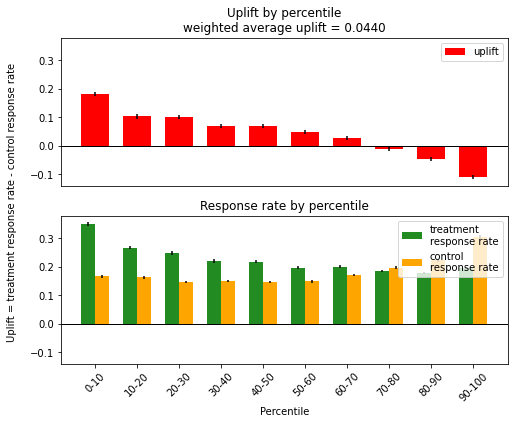

In [20]:
plot_uplift_by_percentile(c_val, uplift, treat_val, 
                          strategy='by_group', kind='bar');

Uplift auc score: 0.08425000618541477


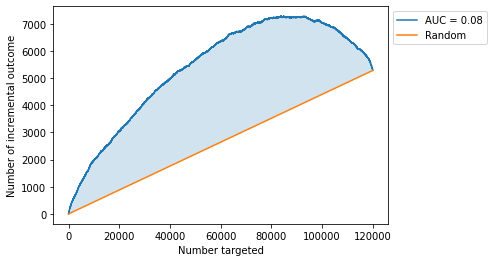

In [21]:
plot_uplift_curve(c_val, uplift, treat_val,
                  perfect=False)

upl_auc_score = uplift_auc_score(c_val, uplift,
                                 treat_val)
print(f'Uplift auc score: {upl_auc_score}')

Qini score: 0.1222048218590976


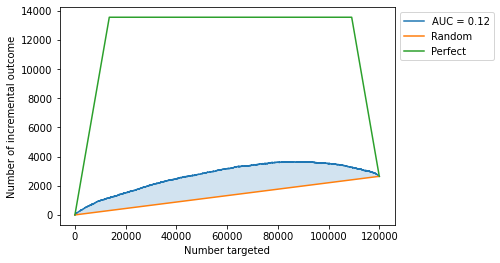

In [22]:
plot_qini_curve(c_val, uplift, treat_val,
                perfect=True)

qini = qini_auc_score(y_true=c_val, uplift=uplift,
                      treatment=treat_val)
print(f'Qini score: {qini}')

# Class transformation подход

<font size=4>
    Вводим новую переменную
    $$Z_i = Y_iW_i + (1 - Y_i)(1 - W_i)$$<br>
    $$
    Z_i =
     \begin{cases}
       1, & W_i = Y_i = 1\\
       1, & W_i = Y_i = 0\\
       0, &\text{иначе}
     \end{cases}
    $$
    <br>
    Можно показать, что<br>
    <center>
        <br>
        $CATE = 2P(Z_i = 1) - 1$
        при соблюдении $CIA$<br>
        <br>
        (для этого достаточно $P(W_i = 1|X_i) = 1/2 \;\forall X_i$)
    </center>
    <br>
</font>

In [23]:
from sklift.models import ClassTransformation

estim = GaussianNB()
model = ClassTransformation(estim)
model.fit(X_train, c_train, treat_tr)
uplift = model.predict(X_val)

In [24]:
upl_k_score = uplift_at_k(y_true=c_val, uplift=uplift,
                treatment=treat_val,
                k=0.1, strategy='by_group')

print(f'Uplift as k score: {upl_k_score}')

Uplift as k score: 0.1805742377106549


In [25]:
uplift_by_percentile(c_val, uplift, treat_val, 
                     strategy='by_group', 
                     total=True, std=True, bins=10)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,6008,5993,0.333222,0.152678,0.180544,0.006081,0.004646,0.007653
10-20,6008,5993,0.257989,0.158018,0.099972,0.005645,0.004712,0.007353
20-30,6008,5993,0.243509,0.155682,0.087827,0.005537,0.004683,0.007252
30-40,6008,5993,0.231358,0.158018,0.073341,0.005441,0.004712,0.007197
40-50,6007,5993,0.221075,0.154680,0.066395,0.005354,0.004671,0.007105
50-60,6007,5993,0.213251,0.165026,0.048225,0.005285,0.004795,0.007136
60-70,6007,5992,0.217080,0.182744,0.034336,0.005319,0.004992,0.007295
70-80,6007,5992,0.204428,0.193925,0.010503,0.005203,0.005108,0.007291
80-90,6007,5992,0.180789,0.229306,-0.048517,0.004965,0.005431,0.007359


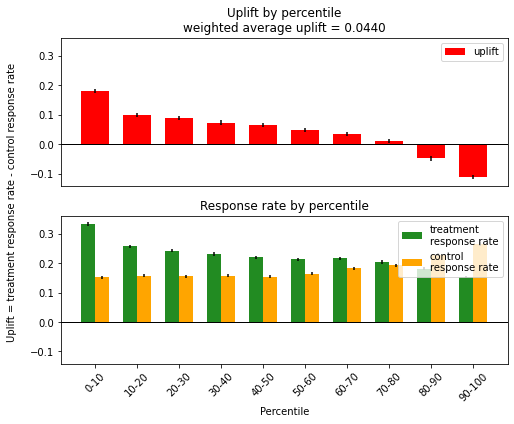

In [26]:
plot_uplift_by_percentile(c_val, uplift, treat_val, 
                          strategy='by_group', kind='bar');

Uplift auc score: 0.08056337966274685


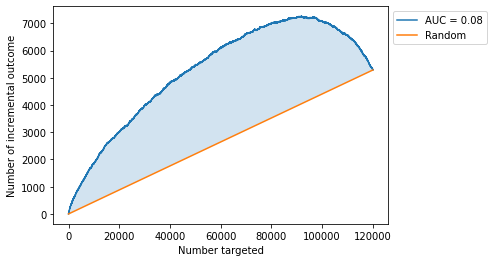

In [27]:
plot_uplift_curve(c_val, uplift, treat_val,
                  perfect=False)

upl_auc_score = uplift_auc_score(c_val, uplift,
                                 treat_val)
print(f'Uplift auc score: {upl_auc_score}')

Qini score: 0.11713975720683639


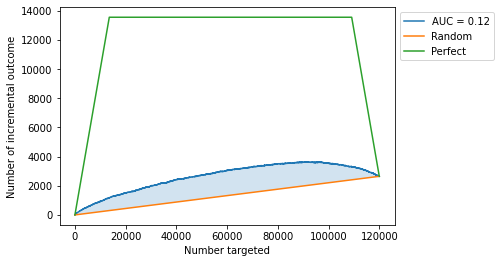

In [28]:
plot_qini_curve(c_val, uplift, treat_val,
                perfect=True)

qini = qini_auc_score(y_true=c_val, uplift=uplift,
                      treatment=treat_val)
print(f'Qini score: {qini}')

# Causal tree model (direct upl. modeling подход)

<font size=4>
    Построим модель, предсказывающую непоср. $uplift_i\;(CATE)$.<br>
    <br>
    Строим дерево реш., в каждом листе будут целевые и конторльные примеры, предсказание - <br>
    <center>
    $$\widehat{CATE} = \frac{Y^T}{N^T} - \frac{Y^C}{N^C}$$
    (Для всех в листе)
    </center>
    <br>
    Как проводить расщепление? Наибольший uplift в листе достигается, когда распр. целев. и контр. групп наиболее разнесены. Можно сравнивать средние, но лучше дивергенцию.
    $$KL(P: Q) = \sum\limits_{i=1}^{N} p_i log_2(\frac{p_i}{q_i})$$<br>
    $$Eucl(P: Q) = \sum\limits_{i=1}^{N} (p_i - q_i)^2$$<br>
    $$\chi^2(P: Q) = \sum\limits_{i=1}^{N} \frac{(p_i - q_i) ^ 2}{q_i}$$<br>
    <br>
    Как померить рост дивергенции? Считаем дивергенцию для примеров в текущем узле <br>
    <br>
    $$D(P^T(Y): P^C(Y))$$
    <br>
    Проводим расщепление $A$, и отдельно считаем дивергенции в потомках $D(P^T(Y|a): P^C(Y|a))$.<br>
    <br>
    Как посчитать её общий уровень?<br>
    Считаем среднее пропорционально примерам в каждом потомке.
    $$D(P^T(Y): P^C(Y)| A) = \sum\limits_{j\,\in\,left,\,right} \frac{N_j}{N} D(P^T(Y|a): P^C(Y|a))$$<br>
    <br>
    Итогов. формула:
    $$D_{gain} = D(P^T(Y): P^C(Y)| A) - D(P^T(Y): P^C(Y))$$
</font>

In [12]:
from sklearn.model_selection import train_test_split as split

X_cut, _, conv_cut, _ = split(X, conv, shuffle=True,
                              stratify=treat, test_size=0.8)
treat_cut = treat[X_cut.index]

X_train, X_val, c_train, c_val = split(X_cut, conv_cut,
                                       test_size=0.3, shuffle=True,
                                       stratify=treat_cut)

treat_tr = treat_cut[X_train.index]
treat_val = 1 * (treat_cut[X_val.index] == 'treatment')

In [14]:
from causalml.inference.tree import UpliftRandomForestClassifier

model = UpliftRandomForestClassifier('control')
model.fit(X_train.values, treat_tr.values, c_train.values)
uplift = model.predict(X_val.values).reshape(-1)

In [15]:
upl_k_score = uplift_at_k(y_true=c_val, uplift=uplift.reshape(-1),
                treatment=treat_val,
                k=0.1, strategy='by_group')

print(f'Uplift as k score: {upl_k_score}')

Uplift as k score: 0.17707864321902891


In [16]:
uplift_by_percentile(c_val, uplift.reshape(-1), treat_val, 
                     strategy='by_group', 
                     total=True, std=True, bins=10)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1803,1798,0.357737,0.180756,0.176981,0.011289,0.009075,0.014484
10-20,1803,1798,0.301719,0.184093,0.117626,0.010810,0.009140,0.014156
20-30,1802,1798,0.259156,0.186874,0.072282,0.010322,0.009193,0.013822
30-40,1802,1798,0.251942,0.169633,0.082309,0.010227,0.008851,0.013525
40-50,1802,1798,0.239734,0.184650,0.055084,0.010057,0.009151,0.013597
50-60,1802,1798,0.219756,0.182981,0.036775,0.009755,0.009119,0.013353
60-70,1802,1798,0.220311,0.180200,0.040111,0.009763,0.009064,0.013322
70-80,1802,1798,0.190899,0.171301,0.019598,0.009258,0.008886,0.012832
80-90,1802,1797,0.182020,0.192543,-0.010523,0.009090,0.009301,0.013005


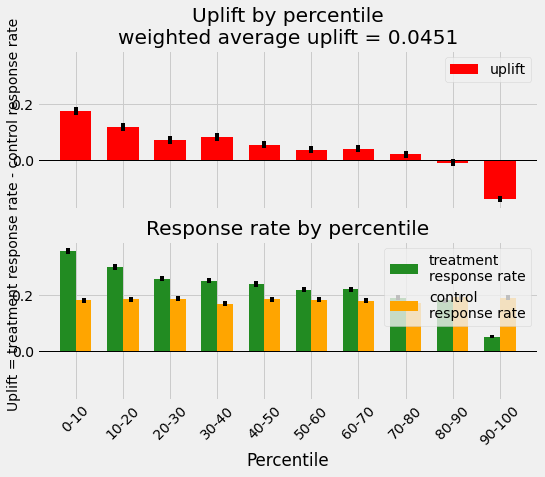

In [17]:
plot_uplift_by_percentile(c_val, uplift, treat_val, 
                          strategy='by_group', kind='bar');

Uplift auc score: 0.0807289878704817


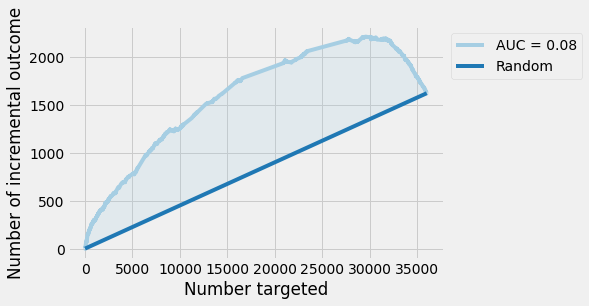

In [18]:
plot_uplift_curve(c_val, uplift, treat_val,
                  perfect=False)

upl_auc_score = uplift_auc_score(c_val, uplift,
                                 treat_val)
print(f'Uplift auc score: {upl_auc_score}')

Qini score: 0.11703903165953312


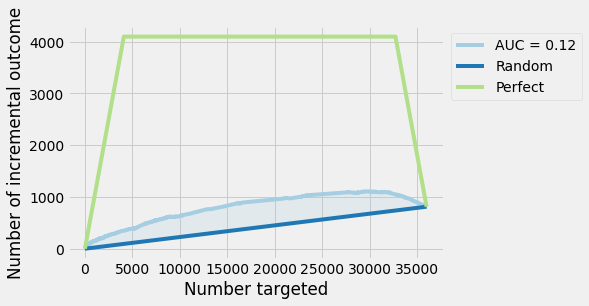

In [19]:
plot_qini_curve(c_val, uplift, treat_val,
                perfect=True)

qini = qini_auc_score(y_true=c_val, uplift=uplift,
                      treatment=treat_val)
print(f'Qini score: {qini}')

# Разбор наилучшего решения

<font size=4>
    Гл. идея - использовать знач. $treatment$ в тестов. выборке.<br>
    Формально это нарушает концепц. uplift modeling.<br>
    Соревновение было посвящ. пониманию метрики $qini$<br>
    Высокие значения не стоит ассоц. с реальными задачами.<br>
    <br>
    Сначала рассм. примитив. решение - открытое знач. $treatment$ позв. нам сначала расположить в выборке все $treat = 1$ перед $treat = 0$ $=> qini \approx 0.56$ 
</font>

In [20]:
uplift = treat_val

Qini score: 0.5577890697671706


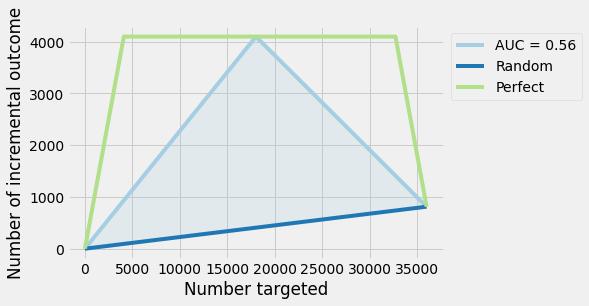

In [21]:
plot_qini_curve(c_val, uplift, treat_val,
                perfect=True)

qini = qini_auc_score(y_true=c_val, uplift=uplift,
                      treatment=treat_val)
print(f'Qini score: {qini}')

<font size=4>
    Далее задача искривить 2 прямые,максимизировав площадь.
    Для этого<br>
    $$if \;treatment_i == 1 => \hat{P}(Y_i = 1|X_i) = model.pred(X_i)$$
    $$if \;treatment_i == 0 => \hat{P}(Y_i = 1|X_i) = -model.pred(X_i)$$
    <br>
    В любом случае целев. и контр. группы не смешиваем.
</font>

In [22]:
model_t = lgb.LGBMClassifier()
model_c = lgb.LGBMClassifier()

model_t.fit(X_treat, c_treat)
model_c.fit(X_ctrl, c_ctrl)

LGBMClassifier()

In [23]:
val_treat = X_val.index[treat_val == 1]
val_ctrl = X_val.index[treat_val != 1]

upl_treat = model_t.predict_proba(X_val.loc[val_treat])[:, 1]
upl_ctrl = -model_c.predict(X_val.loc[val_ctrl])

uplift = np.zeros(len(c_val))
tmp_dict = dict(zip(list(X_val.index), range(len(X_val))))

idx = [tmp_dict[val] for val in val_treat]
uplift[idx] = upl_treat

idx = [tmp_dict[val] for val in val_ctrl]
uplift[idx] = upl_ctrl

In [24]:
c_val_treat = c_val[val_treat]
c_val_ctrl = c_val[val_ctrl]

Qini score: 0.7381967618753085


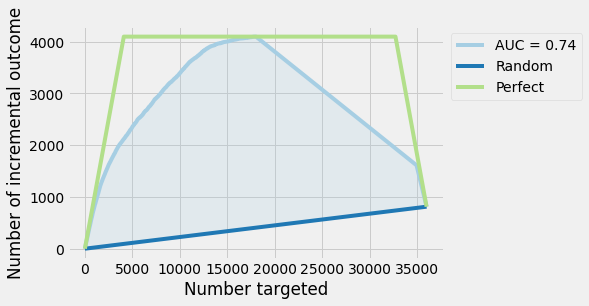

In [25]:
plot_qini_curve(c_val, uplift, treat_val,
                perfect=True)

qini = qini_auc_score(y_true=c_val, uplift=uplift,
                      treatment=treat_val)
print(f'Qini score: {qini}')

In [26]:
upl_k_score = uplift_at_k(y_true=c_val, uplift=uplift,
                          treatment=treat_val,
                          k=0.1, strategy='by_group')

print(f'Uplift as k score: {upl_k_score}')

Uplift as k score: 0.6039888283407355


In [27]:
uplift_by_percentile(c_val, uplift, treat_val, 
                     strategy='by_group', 
                     total=True, std=True, bins=10)

,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1803,1798,0.726012,0.122358,0.603654,0.010504,0.007728,0.013040
10-20,1803,1798,0.383805,0.146830,0.236975,0.011453,0.008347,0.014172
20-30,1802,1798,0.249723,0.120133,0.129589,0.010197,0.007667,0.012758
30-40,1802,1798,0.218646,0.130701,0.087945,0.009737,0.007949,0.012570
40-50,1802,1798,0.203663,0.135150,0.068512,0.009487,0.008063,0.012450
50-60,1802,1798,0.192564,0.147386,0.045178,0.009289,0.008360,0.012497
60-70,1802,1798,0.155383,0.139043,0.016340,0.008534,0.008160,0.011807
70-80,1802,1798,0.077691,0.136819,-0.059127,0.006306,0.008105,0.010269
80-90,1802,1797,0.044395,0.154702,-0.110307,0.004852,0.008531,0.009814


array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0451'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

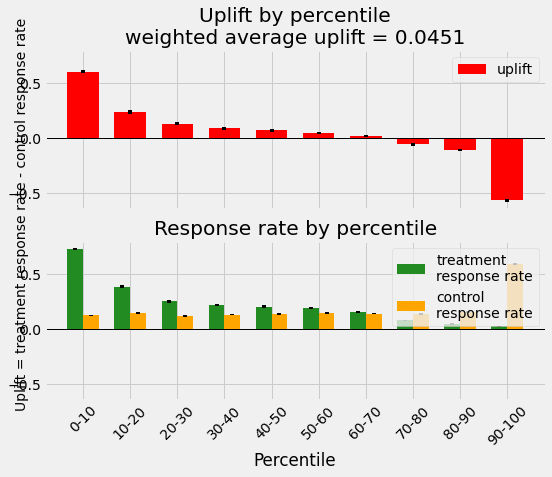

In [28]:
plot_uplift_by_percentile(c_val, uplift, treat_val, 
                          strategy='by_group', kind='bar')

<font size=4>
    Итог по разбору - высокое качество достигнуто подменой задачи.<br>
    В реальной задаче требуется предсказать $CATE$, а затем по нему отобрать $treatment$ и $control$ группы.<br> 
    Здесь изначально даны $treatment$ и $control$, по которым строим оптимальную модель постфактум.
</font>